Load the "Mass" package in R:
Functions and datasets to support Venables and Ripley, ``Modern Applied Statistics with S'' (2002)

In [1]:
library(MASS)

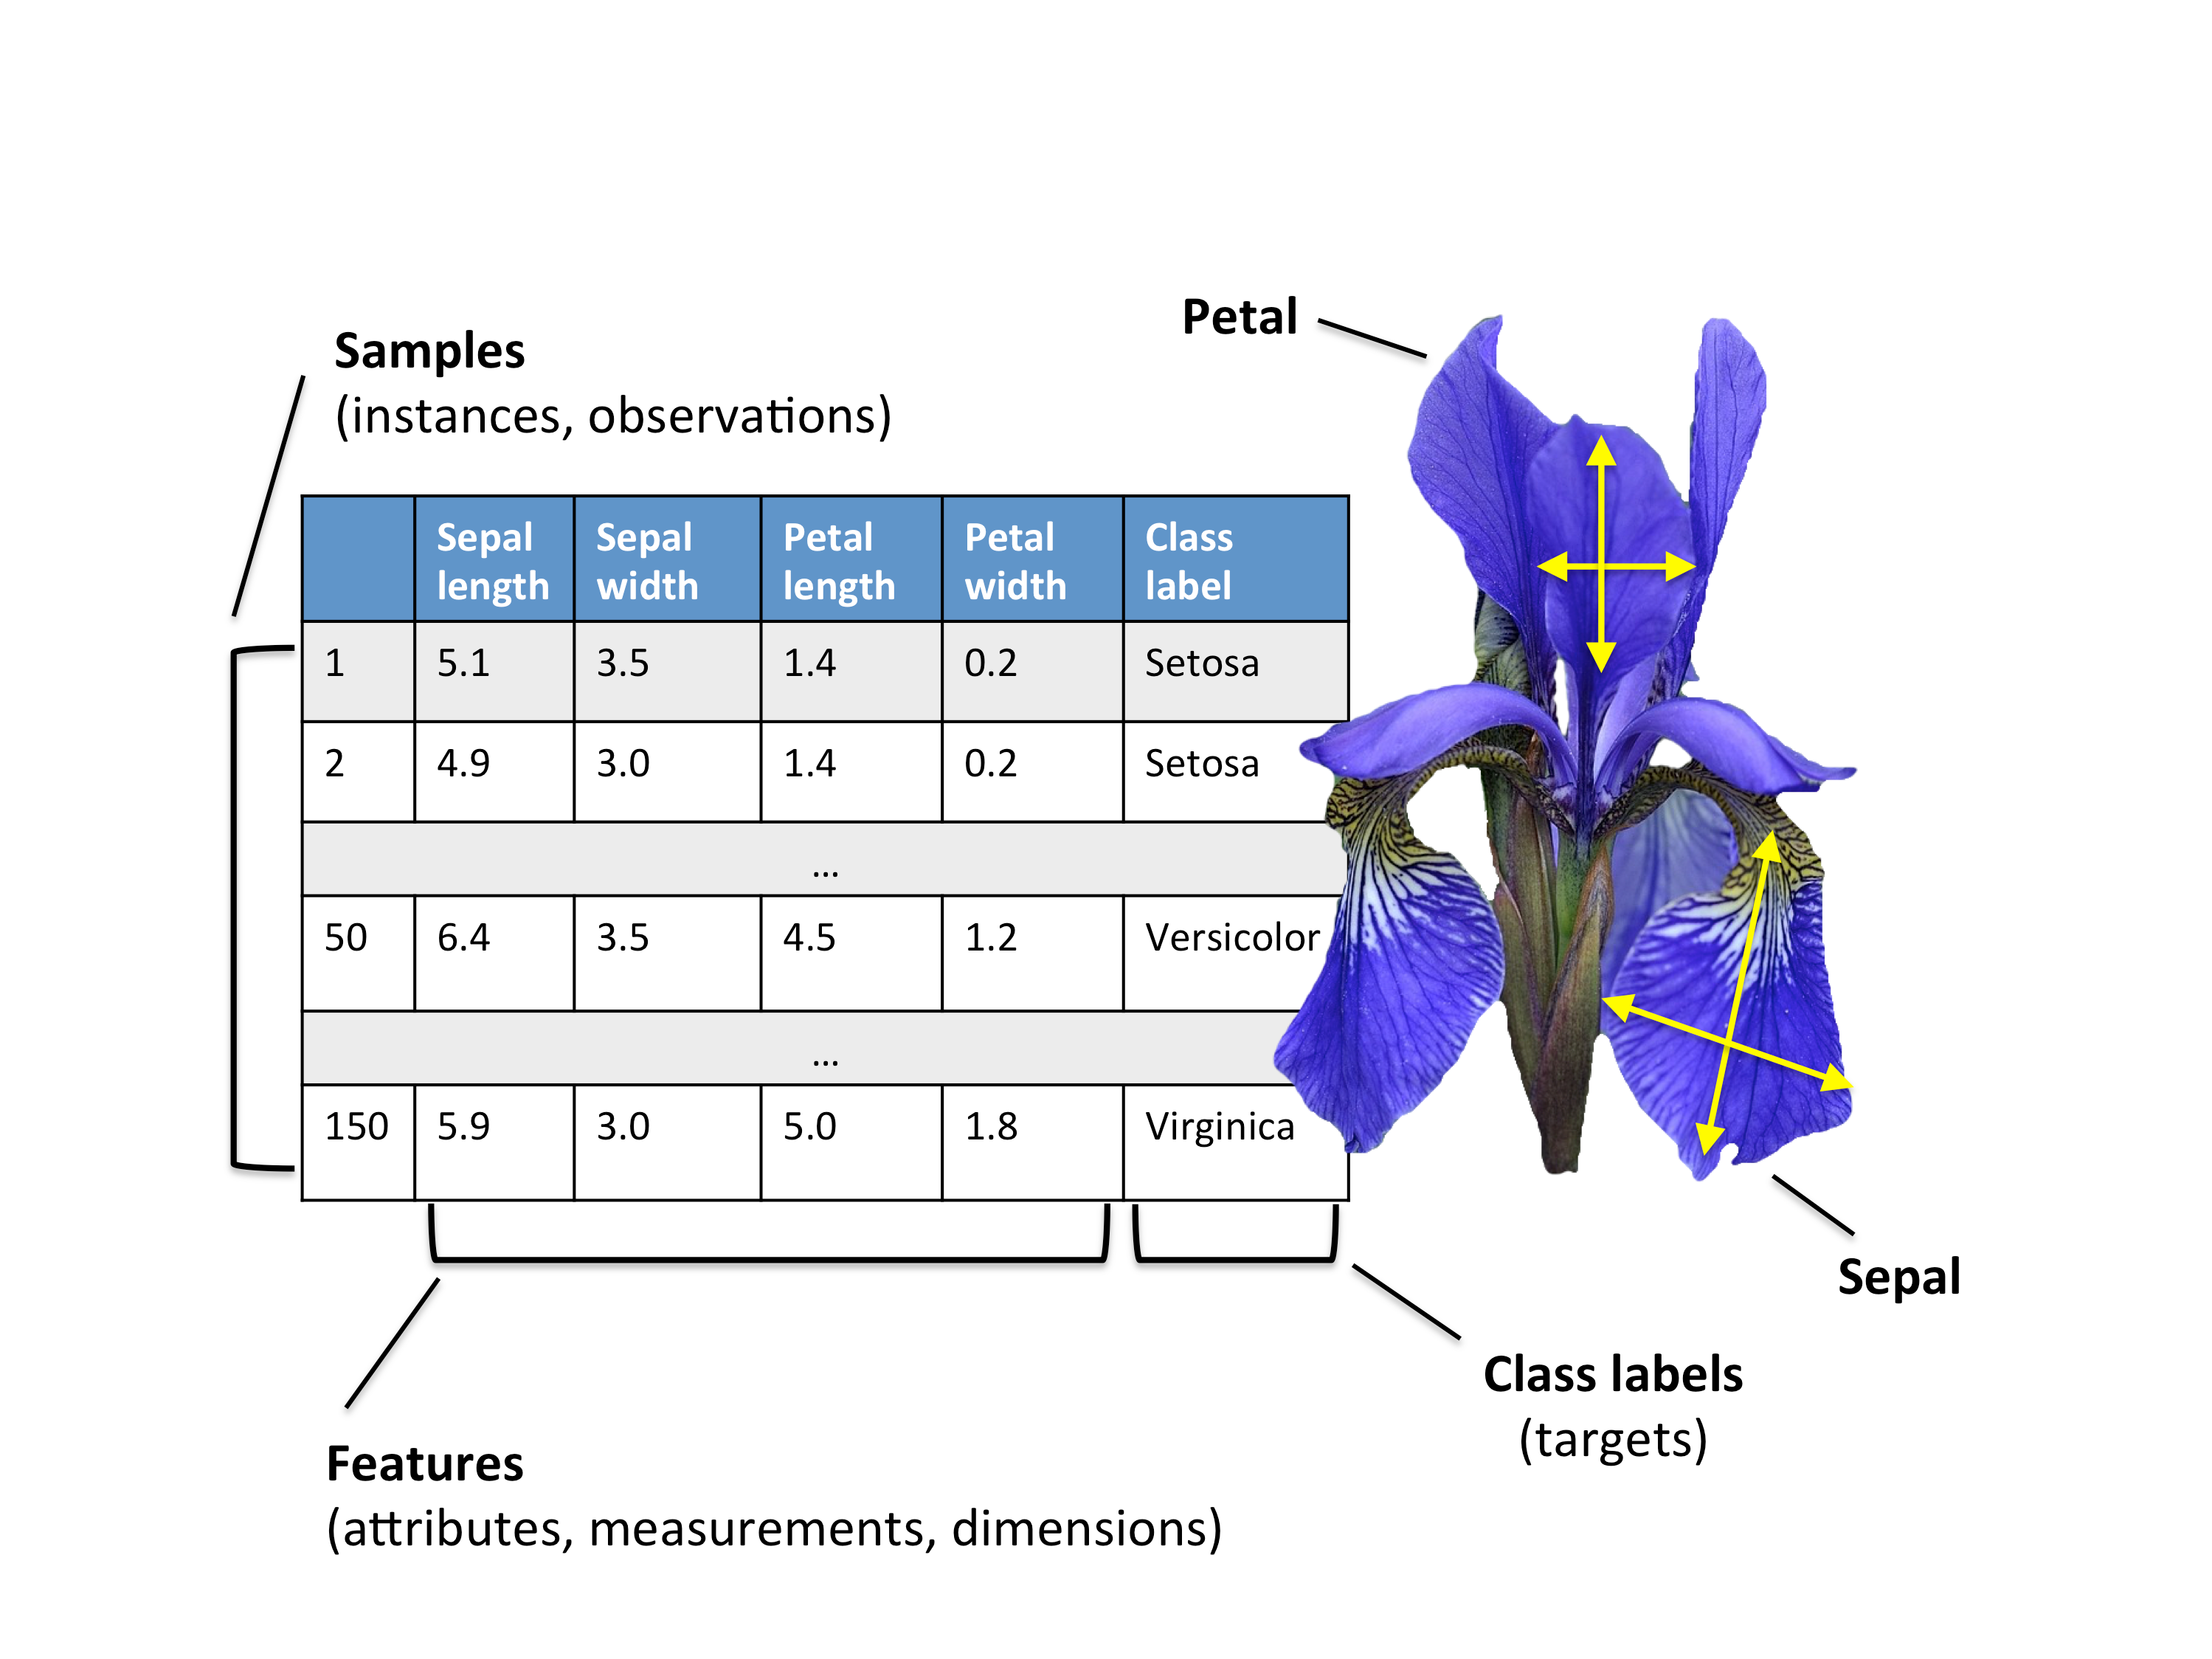

In [2]:
summary(iris)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.057   Mean   :3.758   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
       Species  
 setosa    :50  
 versicolor:50  
 virginica :50  
                
                
                

In [3]:
pairs(iris)

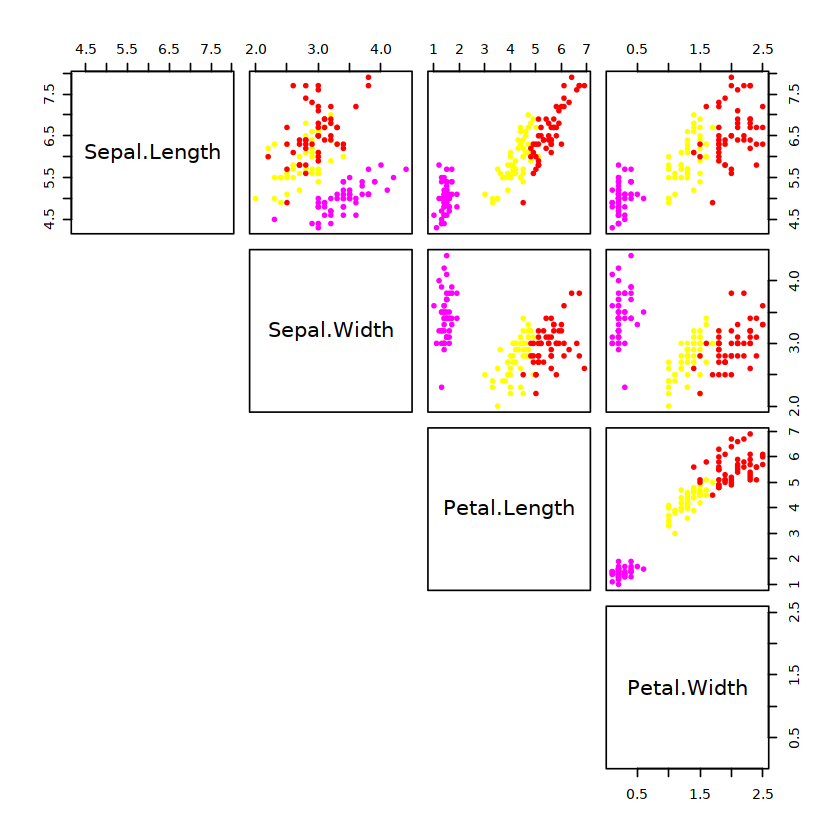

In [4]:
my_cols = c("magenta", "yellow", "red")  
pairs(iris[,1:4], pch = 19,  cex = 0.5,
      col = my_cols[iris$Species],
      lower.panel=NULL)

In [7]:
# setosa is clearly different from the two other Species
# let's build a linear classifier to distinguish "versicolor" and "virginica"
# First step is reducing the sample
irisR=iris[iris$Species != "setosa",]
irisR$Species = factor(irisR$Species)
summary(irisR)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.900   Min.   :2.000   Min.   :3.000   Min.   :1.000  
 1st Qu.:5.800   1st Qu.:2.700   1st Qu.:4.375   1st Qu.:1.300  
 Median :6.300   Median :2.900   Median :4.900   Median :1.600  
 Mean   :6.262   Mean   :2.872   Mean   :4.906   Mean   :1.676  
 3rd Qu.:6.700   3rd Qu.:3.025   3rd Qu.:5.525   3rd Qu.:2.000  
 Max.   :7.900   Max.   :3.800   Max.   :6.900   Max.   :2.500  
       Species  
 versicolor:50  
 virginica :50  
                
                
                
                

In [8]:
# implement LDA 
iris.lda = function(sample) {
 # let's build the LDA classifier:
 # compute means for the two species
 mu0 = colMeans(sample[sample$Species=="versicolor",1:4])
 mu1 = colMeans(sample[sample$Species=="virginica",1:4])
 # compute covariance matrix
 v0 = var(sample[sample$Species=="versicolor",1:4])
 v1 = var(sample[sample$Species=="virginica",1:4])
 invV=solve( (v0+v1)/2)
 cutoff=-0.5*( t(mu0) %*% invV %*% mu0 - t(mu1) %*% invV %*% mu1)
 # compute linear coefficient of the Fisher discriminant
 a = -invV %*% (mu0-mu1)
 list("a"=a,"cutoff"=cutoff)
}

In [9]:
# train LDA and cross-validate with half of data
N=length(irisR$Species)
randomSample=sample(1:N,N/2)
randomSample

[1] 49 44 72 53 11 40 71 19 99 21 60 68 84 73 15  4 86 77 29 42 76 64 47 24 46
[26] 23 41  7 30 74 36 66 22 75 83  9 69 34 33  1 94 81  6 98 37 27 90 55 57 52

In [10]:
trainS=irisR[randomSample,]
testS=irisR[-randomSample,]

In [11]:
summary(trainS)

  Sepal.Length    Sepal.Width     Petal.Length   Petal.Width          Species  
 Min.   :4.900   Min.   :2.000   Min.   :3.00   Min.   :1.000   versicolor:26  
 1st Qu.:5.700   1st Qu.:2.700   1st Qu.:4.50   1st Qu.:1.300   virginica :24  
 Median :6.200   Median :2.800   Median :4.80   Median :1.600                  
 Mean   :6.274   Mean   :2.874   Mean   :4.92   Mean   :1.688                  
 3rd Qu.:6.775   3rd Qu.:3.100   3rd Qu.:5.55   3rd Qu.:2.075                  
 Max.   :7.700   Max.   :3.800   Max.   :6.90   Max.   :2.500                  

cutoff is  16.28287 


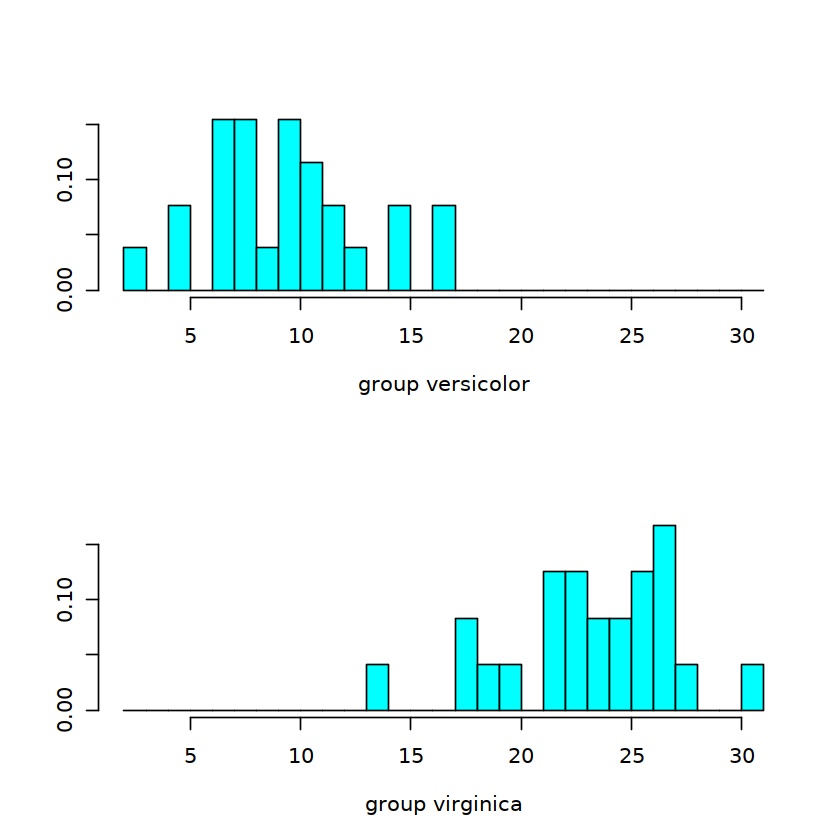

In [12]:
ldaV = iris.lda(trainS)
fisher = as.matrix(trainS[1:4]) %*% ldaV$a
ldahist(fisher,trainS$Species)
cutoff=as.double(ldaV$cutoff)
cat("cutoff is ",cutoff,"\n")

In [13]:
table(fisher > cutoff, trainS$Species, dnn=c('predict Virginica','Real Species'))

                 Real Species
predict Virginica versicolor virginica
            FALSE         24         1
            TRUE           2        23

In [14]:
# use test sample to avoid overtraining
fisher = as.matrix(testS[1:4]) %*% ldaV$a
ldahist(fisher,testS$Species)
table(fisher>cutoff, testS$Species,dnn=c('predict Virginica','Real Species'))

                 Real Species
predict Virginica versicolor virginica
            FALSE         24         2
            TRUE           0        24

In [15]:
# as statistics is limited, it's a pity that training uses only half of data!
# let's use the full sample 
ldaV.full = iris.lda(irisR)
fisher.full= as.matrix(irisR[1:4]) %*% ldaV.full$a
ldahist(fisher.full, irisR$Species)

In [16]:
table(fisher.full > as.double(ldaV.full$cutoff), irisR$Species)

       
        versicolor virginica
  FALSE         48         1
  TRUE           2        49

In [17]:
# check with leave-one-out cross-validation
iris.prediction = function () {
 mypred=c()
 for (i in 1:N) {
   tempIris = irisR[-i,]
   ldaV.temp = iris.lda(tempIris)
   ifisher = as.matrix(irisR[i,1:4]) %*% ldaV.temp$a
   mypred = append(mypred, ifisher > as.double(ldaV.temp$cutoff) )
 }
 mypred
}

In [18]:
cv.prediction=iris.prediction()
table(cv.prediction, irisR$Species,dnn=c('predict Virginica','Real Species'))

                 Real Species
predict Virginica versicolor virginica
            FALSE         48         1
            TRUE           2        49

### Everything can be done in one shot with R's lda function (in the MASS library)

In [19]:
lda.R=lda(Species ~ . , irisR)
lda.R

Call:
lda(Species ~ ., data = irisR)

Prior probabilities of groups:
versicolor  virginica 
       0.5        0.5 

Group means:
           Sepal.Length Sepal.Width Petal.Length Petal.Width
versicolor        5.936       2.770        4.260       1.326
virginica         6.588       2.974        5.552       2.026

Coefficients of linear discriminants:
                    LD1
Sepal.Length -0.9431178
Sepal.Width  -1.4794287
Petal.Length  1.8484510
Petal.Width   3.2847304

In [20]:
# output is equivalent to our computation up to an arbitrary scale factor
lda.R$scaling / ldaV.full$a

LD1      
Sepal.Length 0.2651962
Sepal.Width  0.2651962
Petal.Length 0.2651962
Petal.Width  0.2651962

In [21]:
# leave-one-out cross-validation is done with the CV option
lda.R.cv = lda(Species ~ ., data=irisR, CV=TRUE)
table(lda.R.cv$class, irisR$Species, dnn=c('predicted Species','Real Species'))

                 Real Species
predicted Species versicolor virginica
       versicolor         48         1
       virginica           2        49

### Now let's draw the ROC curve

In [22]:
install.packages("ROCR",lib="../myRlib")

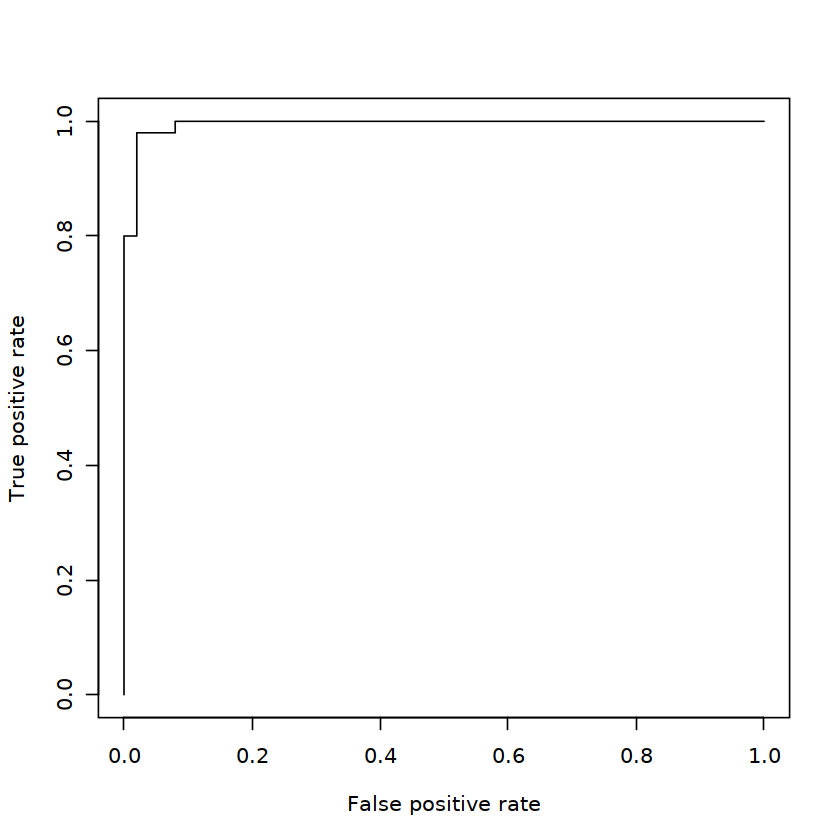

In [23]:
library(ROCR,lib="../myRlib")
mypred <- prediction(lda.R.cv$posterior[,2], irisR$Species) 
myperf <- performance(mypred,"tpr","fpr")
plot(myperf)